Found 3069 images belonging to 2 classes.
Found 764 images belonging to 2 classes.


c:\Users\rajij\anaconda3\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
25/95 [======>.......................] - ETA: 4:11 - loss: 0.7375 - accuracy: 0.4775

c:\Users\rajij\anaconda3\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


95/95 [==============================] - 409s 4s/step - loss: 0.7191 - accuracy: 0.5035 - val_loss: 0.6907 - val_accuracy: 0.6060
Epoch 2/10
95/95 [==============================] - 396s 4s/step - loss: 0.7111 - accuracy: 0.5114 - val_loss: 0.6923 - val_accuracy: 0.5014
Epoch 3/10
95/95 [==============================] - 388s 4s/step - loss: 0.7087 - accuracy: 0.5147 - val_loss: 0.6926 - val_accuracy: 0.4973
Epoch 4/10
95/95 [==============================] - 391s 4s/step - loss: 0.6979 - accuracy: 0.5199 - val_loss: 0.6960 - val_accuracy: 0.5000
Epoch 5/10
95/95 [==============================] - 394s 4s/step - loss: 0.6987 - accuracy: 0.5258 - val_loss: 0.6905 - val_accuracy: 0.5054
Epoch 6/10
95/95 [==============================] - 388s 4s/step - loss: 0.6968 - accuracy: 0.5216 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 7/10
95/95 [==============================] - 386s 4s/step - loss: 0.6895 - accuracy: 0.5336 - val_loss: 0.6891 - val_accuracy: 0.5177
Epoch 8/10
95/95 [======

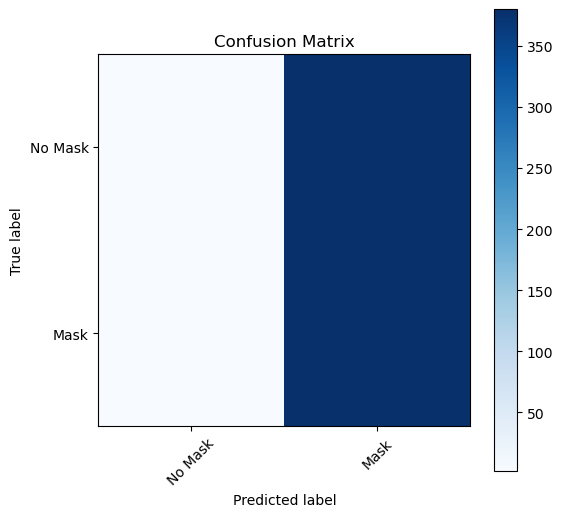

1/1 [==============================] - 2s 2s/step
No mask detected.
1/1 [==============================] - 0s 165ms/step
No mask detected.


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

# Load the dataset (assuming images are in 'train' and 'val' directories with subfolders for 'mask' and 'no_mask')
train_dir = 'C:/Users/rajij/Downloads/dataset/train'
val_dir = 'C:/Users/rajij/Downloads/dataset/test'

# Data Preprocessing: Rescale images and apply augmentation to training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')  # Assuming binary classification (mask or no mask)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

# Load the pretrained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base layers of ResNet50 and train only the custom layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_resnet50.compile(optimizer=Adam(lr=1.0000e-05), loss='binary_crossentropy', metrics=['accuracy'])

#using early stopping to prevent model overfitting

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping])

# Evaluate the model on validation data
val_labels = validation_generator.classes  # Actual labels
y_pred_probs = model_resnet50.predict(validation_generator)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate the evaluation metrics
accuracy = accuracy_score(val_labels, y_pred)
precision = precision_score(val_labels, y_pred)
recall = recall_score(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred)
conf_matrix = confusion_matrix(val_labels, y_pred)

# Print evaluation results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Optionally plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Mask', 'Mask'], rotation=45)
plt.yticks(tick_marks, ['No Mask', 'Mask'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


#Make Prediction
#with mask

import cv2
import numpy as np

# Load an image
img_path = 'C:/Users/rajij/Downloads/testmodel1.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))  # Resize to 224x224
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = img / 255.0  # Rescale

# Make prediction
prediction = model_resnet50.predict(img)
if prediction[0] > 0.5:
    print("Mask detected!")
else:
    print("No mask detected.")

#Make Prediction
#without mask
# 
# Load an image
img_path = 'C:/Users/rajij/Downloads/testmodel3_no.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))  # Resize to 224x224
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = img / 255.0  # Rescale

# Make prediction
prediction = model_resnet50.predict(img)
if prediction[0] > 0.5:
    print("Mask detected!")
else:
    print("No mask detected.")    

In [ ]:
img_path = 'C:/Users/rajij/Downloads/testmodel5.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))  # Resize to 224x224
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = img / 255.0  # Rescale

# Make prediction
prediction = model_resnet50.predict(img)
if prediction[0] > 0.5:
    print("Mask detected!")
else:
    print("No mask detected.")

1/1 [==============================] - 0s 262ms/step
No mask detected.
1/1 [==============================] - 0s 262ms/step
No mask detected.


In [ ]:
img_path = 'C:/Users/rajij/Downloads/testmodel6_no.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))  # Resize to 224x224
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = img / 255.0  # Rescale

# Make prediction
prediction = model_resnet50.predict(img)
if prediction[0] > 0.5:
    print("Mask detected!")
else:
    print("No mask detected.")

1/1 [==============================] - 0s 303ms/step
No mask detected.
1/1 [==============================] - 0s 303ms/step
No mask detected.


In [ ]:
img_path = 'C:/Users/rajij/Downloads/testmodel4.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))  # Resize to 224x224
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = img / 255.0  # Rescale

# Make prediction
prediction = model_resnet50.predict(img)
if prediction[0] > 0.5:
    print("Mask detected!")
else:
    print("No mask detected.")

1/1 [==============================] - 0s 257ms/step
Mask detected!
1/1 [==============================] - 0s 257ms/step
Mask detected!
